In [ ]:
import tensorflow as tf
import numpy as np

import zipfile
import os
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the TensorBoard notebook extension
%load_ext tensorboard
%rm -rf ./logs/
import datetime

%pip install visualkeras
import visualkeras
from collections import defaultdict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras import layers
from keras import initializers

# Preparing Data

In [ ]:
# Done for the transfer learning model
imageSize = (104,88) # IMG_SIZE = (160, 160)
seed_value = 2
# tf.random.set_seed(seed_value) 

In [ ]:
def outImg(arr):
  for I in arr:
    imgplot = plt.imshow(I)
    plt.show()

In [ ]:
# Unzips file in path and extracts in to folder
with zipfile.ZipFile('/content/data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [ ]:
# Gets all the class names
datasetPath = '/content/data/data/' # Change for data sets

classes = os.listdir(datasetPath)
# Adding all data to dataFiles
dataFiles = np.empty(shape=(0,2))
for c in classes:
  # Creates the image file path in element [0] and the class of the image in element [1]
  imgFile = np.array(list(map(lambda x: (f'{datasetPath}{c}/{x}', c), os.listdir(f'{datasetPath}{c}'))))
  prevLength = len(dataFiles)
  
  dataFiles = np.concatenate((dataFiles, imgFile))
  
  print(f'{datasetPath}{c}: {len(dataFiles)} image files total. {len(dataFiles) - prevLength} images in class {c}')

dataSet = np.array(list(map(lambda x: (io.imread(x[0]), x[1]), dataFiles)))


/content/data/data/Mild_Demented: 896 image files total. 896 images in class Mild_Demented
/content/data/data/Very_Mild_Demented: 3136 image files total. 2240 images in class Very_Mild_Demented
/content/data/data/Non_Demented: 6336 image files total. 3200 images in class Non_Demented
/content/data/data/Moderate_Demented: 6400 image files total. 64 images in class Moderate_Demented


<ipython-input-6-8eb7c7199eee>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataSet = np.array(list(map(lambda x: (io.imread(x[0]), x[1]), dataFiles)))


**Indexing Labels**

In [ ]:
## Making class dictionary to chnage class labels to numbers
strDict = {"Non_Demented": 0, "Very_Mild_Demented": 1,   "Mild_Demented": 2, "Moderate_Demented": 3} # Change for data sets

# dataSet is split into images and labels
images = dataSet[:,0]
labels = dataSet[:,1]


print(labels[0:5])
listLabels = list(labels)
labels = np.array(list(map(lambda x: strDict[x], listLabels)))
print(labels[0:5])

['Mild_Demented' 'Mild_Demented' 'Mild_Demented' 'Mild_Demented'
 'Mild_Demented']
[2 2 2 2 2]


**Re-sizing Images**

**Final Touches**

In [ ]:
# Data is split into training and testing
# images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.33)

# Data is split into training and testing
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.33) # Take out random_state = seed_value when testing without a fair test

# Training data is split into validation data
# images_train, images_val, labels_train, labels_val = train_test_split(images_train, labels_train, test_size=0.2, random_state=seed_value)



# Deleting unessisary varibales to free up colab memory
del(images)
del(labels)
del(listLabels)


images_train = np.array([np.array(val) for val in images_train])
images_test = np.array([np.array(val) for val in images_test])
# images_val = np.array([np.array(val) for val in images_val])

new_images_train = []
for im in images_train:
  im = resize(im, imageSize, anti_aliasing=True)
  new_images_train.append(im)
images_train = new_images_train

new_images_test = []
for im in images_test:
  im = resize(im, imageSize, anti_aliasing=True)
  new_images_test.append(im)
images_test = new_images_test

# new_images_val = []
# for im in images_val:
#   im = resize(im, imageSize, anti_aliasing=True)
#   new_images_val.append(im)
# images_val = new_images_val

# images_train = tf.expand_dims(images_train, axis=-1)
# images_test = tf.expand_dims(images_test, axis=-1)

images_train = np.stack((images_train,)*3, axis=-1)
images_test = np.stack((images_test,)*3, axis=-1)
# images_val = np.stack((images_val,)*3, axis=-1)

# print(tf.shape(images_train))

#outImg(images_train[0:5])
del(new_images_test)
del(new_images_train)
# del(new_images_val)

In [ ]:
tempDict = {"train": {"non":0,"veryMild":0,"mild":0,"mod":0}, "test": {"non":0,"veryMild":0,"mild":0,"mod":0}}
# Loops over training images and tells how many of each class there are
for sample in labels_train:
  if (sample == 0):
    tempDict["train"]["non"]+=1
  elif (sample == 1):
    tempDict["train"]["veryMild"]+=1
  elif (sample == 2):
    tempDict["train"]["mild"]+=1
  elif (sample == 3):
    tempDict["train"]["mod"]+=1

for sample in labels_test:
  if (sample == 0):
    tempDict["test"]["non"]+=1
  elif (sample == 1):
    tempDict["test"]["veryMild"]+=1
  elif (sample == 2):
    tempDict["test"]["mild"]+=1
  elif (sample == 3):
    tempDict["test"]["mod"]+=1

print(tempDict)

{'train': {'non': 2157, 'veryMild': 1478, 'mild': 616, 'mod': 37}, 'test': {'non': 1043, 'veryMild': 762, 'mild': 280, 'mod': 27}}


**Data Generator**

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size):
    self.x, self.y = x_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(x_data) / batch_size)
    self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_x = self.x[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return batch_x, batch_y

train_generator = DataGenerator(images_train, labels_train, batch_size = 16)
test_generator = DataGenerator(images_test, labels_test, batch_size = 16)
#val_generator = DataGenerator(images_val, labels_val, batch_size = 16)

# Creating Model

In [ ]:
# kernel_initialiser = initializers.RandomNormal(seed=seed_value)
# bias_initialiser =  initializers.Zeros() # HERE

# Get pre-built model
base_model = tf.keras.applications.resnet50.ResNet50(weights = "imagenet",
                                                 include_top = False,
                                                 input_shape = (imageSize[0], imageSize[1],3),
                                                 pooling = "avg")
# Add prebuilt model to output dense layer
model = tf.keras.models.Sequential(
    [
        base_model,
        tf.keras.layers.Dense(4,activation = "softmax")
    ]
)
base_model.trainable = False # Sets transfer learning layer to not be trainable
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # sparse_categorical_crossentropy
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Lower learning rate as it is huge model
                  metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Tensorbaord
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.evaluate(test_generator)

132/132 [==============================] - 84s 589ms/step - loss: 1.5039 - accuracy: 0.3608


[1.503915548324585, 0.3607954680919647]

# Retraining

In [ ]:
epochs = 5
model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[tensorboard_callback]) 

Epoch 1/5
268/268 [==============================] - 182s 665ms/step - loss: 1.0400 - accuracy: 0.4979
Epoch 2/5
268/268 [==============================] - 166s 619ms/step - loss: 1.0176 - accuracy: 0.5072
Epoch 3/5
268/268 [==============================] - 168s 629ms/step - loss: 1.0090 - accuracy: 0.5044
Epoch 4/5
268/268 [==============================] - 167s 624ms/step - loss: 0.9988 - accuracy: 0.5089
Epoch 5/5
268/268 [==============================] - 166s 617ms/step - loss: 0.9931 - accuracy: 0.5149


In [ ]:
model.evaluate(test_generator, verbose=1)

132/132 [==============================] - 78s 591ms/step - loss: 1.0185 - accuracy: 0.5057


[1.0185229778289795, 0.5056818127632141]

# Retraining Base model <br>
Classifier on top of base model should be trained seperatly from the base model itself. <br>
Got to recompile the model with the upper layers unfrozen, then retrain.

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100
base_model.trainable = True # Setting it false
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # sparse_categorical_crossentropy
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower learning rate as it is huge model
                  metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 19,461,124
Non-trainable params: 4,134,784
_________________________________________________________________


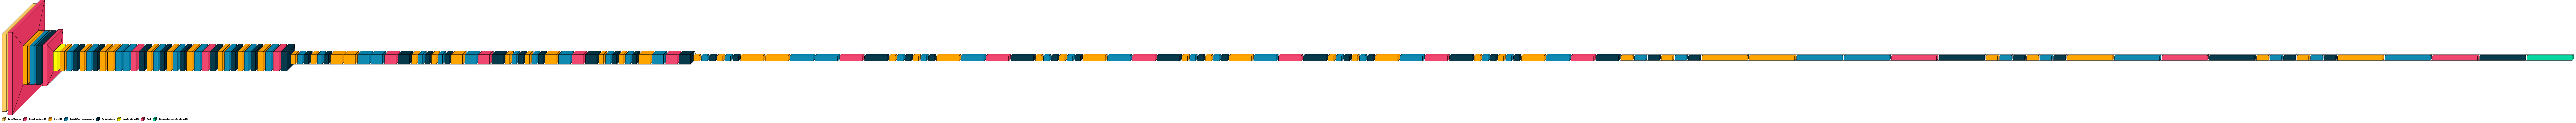

In [ ]:
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#FFA500'
color_map[layers.Dropout]['fill'] = '#ADD8E6'
color_map[layers.MaxPooling2D]['fill'] = '#FFFF00'
color_map[layers.Dense]['fill'] = '#1616FF'
color_map[layers.Flatten]['fill'] = 'green'

visualkeras.layered_view(base_model, legend=True, color_map=color_map) # Visualisation of model

In [ ]:
fine_tune_epochs = 45 # 45
total_epochs =  epochs + fine_tune_epochs

model.fit(train_generator, epochs=total_epochs, initial_epoch=epochs, verbose=1, callbacks=[tensorboard_callback]) 

Epoch 6/50
268/268 [==============================] - 557s 2s/step - loss: 1.1129 - accuracy: 0.5184
Epoch 7/50
268/268 [==============================] - 546s 2s/step - loss: 0.9464 - accuracy: 0.5634
Epoch 8/50
268/268 [==============================] - 555s 2s/step - loss: 0.9077 - accuracy: 0.5819
Epoch 9/50
268/268 [==============================] - 555s 2s/step - loss: 0.8360 - accuracy: 0.6208
Epoch 10/50
268/268 [==============================] - 554s 2s/step - loss: 0.7900 - accuracy: 0.6392
Epoch 11/50
268/268 [==============================] - 559s 2s/step - loss: 0.7837 - accuracy: 0.6416
Epoch 12/50
268/268 [==============================] - 534s 2s/step - loss: 0.7338 - accuracy: 0.6712
Epoch 13/50
268/268 [==============================] - 536s 2s/step - loss: 0.7033 - accuracy: 0.6842
Epoch 14/50
268/268 [==============================] - 534s 2s/step - loss: 0.6780 - accuracy: 0.6992
Epoch 15/50
214/268 [======================>.......] - ETA: 1:45 - loss: 0.6456 - accu

In [ ]:
model.evaluate(test_generator, verbose=1)

# Metrics

In [ ]:
predictions = list(model.predict(images_test))

# strDict = {"Non_Demented": 0, "Very_Mild_Demented": 1,   "Mild_Demented": 2, "Moderate_Demented": 3}
# Reversing the dictionary
indexDict = {}
for record in strDict.items():
  indexDict[record[1]] = record[0]
print(indexDict)

# Gets the class index output
class_pred = np.argmax(predictions, axis=1)
print("Turning index output into string classes...\n")
print(class_pred[0:10])
class_pred = list(map(lambda x: indexDict[x], class_pred))
print(class_pred[0:10])

print("Turning test labels into string classes...\n")
print(labels_test[0:10])
true_class = list(map(lambda x: indexDict[x], labels_test))
print(true_class[0:10])

In [ ]:
accuracy = accuracy_score(true_class, class_pred)
CM = confusion_matrix(y_true=true_class, y_pred=class_pred
                      , labels=["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"]) # labels=["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"]


globalPrecision = precision_score(true_class, class_pred, average="macro"
                            , labels=["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"])
globalRecall = recall_score(true_class, class_pred, average="macro"
                      , labels=["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"])
globalF1Score = f1_score(true_class, class_pred, average="macro"
                   , labels=["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"])


classPrecision = precision_score(true_class, class_pred, average=None
                            , labels=["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"])
classRecall = recall_score(true_class, class_pred, average=None
                      , labels=["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"])
classF1Score = f1_score(true_class, class_pred, average=None
                   , labels=["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"])

print("Running metrics on output of model:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {globalPrecision}")
print(f"Recall: {globalRecall}")
print(f"F1 Score: {globalF1Score}")

print("\n\nRunning metrics on all classes\nNon_Demented, Very_Mild_Demented, Mild_Demented, Moderate_Demented")
print(f"Precision: {classPrecision}")
print(f"Recall: {classRecall}")
print(f"F1 Score: {classF1Score}")
print(f"\n\nConfusion Matrix:\n{CM}")

In [ ]:
%tensorboard --logdir logs/fit